# Identifying current flows across the GBR during COTS larval spawning times

***Group 1, ENVI5809, Semester 2 2022***

*Beatriz Boggiani, Md. Yousef Gazi, Lachlan Perris, Jonathon Leonard*

*Note this code has been adapted from tutorials provided by Tristan Salles and the Ocean Parcels Development Team*

This notebook is to accompany the report, presentation and additional notebooks for the ENVI5809 project. In this notebook, supplementary current data is accessed for the report. 

Before starting, let's import any required libraries.

In [2]:
import sys, os, random, itertools
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean
import imageio

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
import datetime as dtime
from datetime import datetime
from datetime import timedelta
from operator import attrgetter

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.ion()  # To trigger the interactive inline mode
plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (20,15) # Change default figure size
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'axes.labelsize':16})

C:\Users\lachl\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lachl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lachl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\lachl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We also define a few handy variables

In [3]:
data_name ='curr_ereefdata_-0.5.nc' # The name of the combined .nc grid of all the months of current data combined
data_name2 ='curr_ereefdata_-1.5.nc'
# The coordinates of some North Queensland towns (for plotting)
cairnsLat, cairnsLon = -16.92, 145.77
rockhamptonLat, rockhamptonLon = -23.38, 150.51
bowenLat, bowenLon = -20.01, 148.25

Also some plotting functions to make things easy and consistent

In [4]:
def plot_town(townname='cairns'):
    lat = f'{townname}Lat'
    lon = f'{townname}Lon'
    plt.plot(globals()[lon], globals()[lat], color='red', marker='s', linewidth=2, mew=0.1, mec='black', transform=ccrs.PlateCarree())
    plt.text(globals()[lon]-0.2, globals()[lat]-0.1, f'{townname.capitalize()}', horizontalalignment='right', transform=ccrs.PlateCarree())

## Locate COTS outbreaks

Load and set-up the COTS observation data from AIMS. 
The data is available here: https://apps.aims.gov.au/metadata/view/5bb9a340-4ade-11dc-8f56-00008a07204e


In [5]:
data = 'datasets/manta-tow-by-reef/manta-tow-by-reef.csv' # path to manta-tow data saved locally
df = pd.read_csv(data) # Read the manta-tow data into pandas

# Drop unneeded columns
df = df.drop(columns=['SECTOR','SHELF','REEF_ID','P_CODE','VISIT_NO', 'REPORT_YEAR','MEDIAN_LIVE_CORAL','MEDIAN_SOFT_CORAL', 'MEDIAN_DEAD_CORAL',
       'MEAN_LIVE_CORAL', 'MEAN_SOFT_CORAL', 'MEAN_DEAD_CORAL', 'TOTAL_TROUT', 'MEAN_TROUT_PER_TOW', 'TOWS'])

# Convert date column to datetime
df['SAMPLE_DATE'] = pd.to_datetime(df['SAMPLE_DATE']) 

# Add year and month columns for easier processing later on
df['YEAR'] = df['SAMPLE_DATE'].dt.year
df['MONTH'] = df['SAMPLE_DATE'].dt.month

df.head(2) # Check the data has loaded correctly

,REEF_NAME,LATITUDE,LONGITUDE,YEAR_CODE,SAMPLE_DATE,TOTAL_COTS,MEAN_COTS_PER_TOW,YEAR,MONTH
0,LOW ISLANDS REEF,-16.383333,145.566667,199293,1993-06-11,0,0.0,1993,6
1,LOW ISLANDS REEF,-16.383333,145.566667,199596,1996-01-15,0,0.0,1996,1


Now we can plot all our data to get a rough idea of some of the patterns and how it looks. The below graph shows that COTS outbreaks are seasonal, with most appearing at the beginning of the year. We can also see clusters of very high outbreaks around the year 2000 and 2018.

### Identify large COTS numbers

As a rough identification of large outbreaks, let's identify only outbreaks that are significantly larger than the mean value.

In [6]:
mean = df['MEAN_COTS_PER_TOW'].mean()
print(f"The average COTS per tow detected across the whole dataset is {round(mean,3)}")

# Let's work with all data that has recorded at least some COTS (so we can get closer to a normal distribution and using standard deviation makes a bit more sense)
df_nonzero = df[df['MEAN_COTS_PER_TOW'] > 0]
mean_nonzero = df_nonzero['MEAN_COTS_PER_TOW'].mean()
std_nonzero = df_nonzero['MEAN_COTS_PER_TOW'].std()

# Now add a new column to the original dataset that displays the standard deviation for non-zero Mean-COTS-per-tow data
df['DEVIATION'] = np.abs(df['MEAN_COTS_PER_TOW']/std_nonzero)

The average COTS per tow detected across the whole dataset is 0.295


## Plot Current Data

Now that we have identified times and locations on COTS outbreaks, we can use eReefs to plot mean currents levels around those times.

### eReefs Map Function

In [12]:
def ereefs_map(nc_data, tindex, depth, variable, extent, color, size, figname='untitled', zoom=None, show=True, save=False):
    dir_name = f'{figname}_images'
    os.makedirs(dir_name, exist_ok=True) # Make directory to put the images in 
    
    # data = nc_data[variable][tindex, depth, :,:] # produces an array
    data = nc_data[variable][tindex, :,:] # Currently have sliced grid to one depth level so taken depth out
    lat = nc_data['latitude'][:]
    lon = nc_data['longitude'][:]
    time = nc_data.variables['time']
    
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.set_extent([np.min(lon), np.max(lon), np.max(lat), np.min(lat)], ccrs.PlateCarree())
    ax.set_extent([143, 153, -9.5, -25], ccrs.PlateCarree())
    
    plot = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto', 
                          vmin=extent[0], vmax=extent[1], 
                          transform=ccrs.PlateCarree())
    
    
    
    #This plots arrows for currents:

    # Resampling using the slice method
    resample = ds_hydro_clip.isel(time=t,longitude=slice(None, None, 7),latitude=slice(None, None, 7))

    # Defining the quiver plot
    quiver = resample.plot.quiver(x='longitude', y='latitude', u='u', v='v', transform=ccrs.PlateCarree(), scale=8)  
    # Vector options declaration
    veclenght = 0.5
    maxstr = '%3.1f m/s' % veclenght
    plt.quiverkey(quiver,0.1,0.1,veclenght,maxstr,labelpos='S', 
              coordinates='axes').set_zorder(11)

    
    

    
    # Plot towns
    plot_town(townname='cairns')
    plot_town(townname='rockhampton')
    plot_town(townname='bowen')
    
    # Color bar
    cbar = fig.colorbar(plot, ax=ax, fraction=0.027, pad=0.035, orientation='horizontal')
    cbar.set_label(nc_data[variable].units, fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    # Title
    dtime = nc.num2date(nc_data['time'][tindex],nc_data['time'].units)
    time_format = dtime.strftime('%b %d %Y %I%p')
    plt.title(f"{nc_data[variable].long_name} {time_format}", fontsize=14, pad=4)
    
    # Plot lat/lon grid
    gridlines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=1, linestyle='--')
    gridlines.top_labels =  False
    gridlines.right_labels = False
    
    gridlines.xformatter = LONGITUDE_FORMATTER # from cartopy mpl gridliner class
    gridlines.yformatter = LATITUDE_FORMATTER
    
    gridlines.xlabel_style = {'size': 8}
    gridlines.ylabel_style = {'size': 8}
    
    # Add features from a shapefile, this shapefile is of reef features in the GBR
    ax.add_feature(cartopy.feature.ShapelyFeature(shpreader.Reader('datasets/Shapefiles/GBR_Features.shp').geometries(), 
                                                   ccrs.PlateCarree(), facecolor="lightgrey", edgecolor='black', lw=0.05))
    
    
    # Add map features from cartopy
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', 
                                                edgecolor='darkblue', 
                                                facecolor='none'))
    ax.coastlines(linewidth=1)
    
    if zoom is not None:
        plt.xlim(zoom[0],zoom[2])
        plt.ylim(zoom[1],zoom[3])
         
    imname = f"{figname}_{dtime.strftime('%b_%d_%Y_%I%p')}_zc{depth:04}.png"
    impath = f'{dir_name}/{imname}'
    if os.path.isfile(impath):
        os.remove(impath)
    
    if show:
        if save:
            plt.savefig(impath,dpi=300, 
                    bbox_inches='tight')
            # images.append(imageio.imread(imname))
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(impath,dpi=300, 
                    bbox_inches='tight')
        # images.append(imageio.imread(imname))

    fig.clear()
    plt.close(fig)
    plt.clf()
    
    return impath

### Retrieving eReefs Data

In [8]:
# The stem of a url where ereefs data will be retrieved
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

# Choose the variable and depth to plot

variable = 'mean_cur' # We want the current data
depthIndex = -1 # Depth does from deepest-shallowest, so -1 will be the shallowest layer (i.e. the surface)

# Choose the time frame to plot
cots_months = [11,12,1,2] # The months where cots larvae breed
year_st = 2017 # Starting year (so Dec 2018 for example)

# Use indexing to get the month-year .nc files 
years = []
hydrofiles = [] # Empty list where the desired eReefs filenames will be appended
for m in range(len(cots_months)): 
    month = cots_months[m]
    if m == 0: # For the first month in our list, the year is the start year
        year = year_st
        years.append(year)
    elif cots_months[m] > cots_months[m-1]:
        year = years[m-1]
        years.append(year)
    else:
        year = year_st + 1
        years.append(year)
    
    hydrofile = f"{base_url}{year}-{month:02}.nc"
    hydrofiles.append(hydrofile)

ds_hydro = xr.open_mfdataset(hydrofiles)

The eReefs files are large, so we slide them to the areas we are mainly interested in

In [9]:
# Only plot data where high amounts of COTS are found. Here we use the manta-tow COTS data- all the occasions where mean-cot-per-tow was recorded
min_lon = df['LONGITUDE'].min() - 1     # lower left longitude
min_lat = df['LATITUDE'].min() - 1      # lower left latitude
max_lon = df['LONGITUDE'].max() + 1      # upper right longitude
max_lat = df['LATITUDE'].max() + 1      # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Slicing the grid and only taking the surface dataset (k=-1)
ds_hydro_clip = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-1)
ds_hydro_clip2 = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-2)

# Dropping unused variables
surf_data = ds_hydro_clip.drop(['zc','mean_wspeed','temp',
                    'eta','wspeed_u','wspeed_v', 'salt'])

deep_data = ds_hydro_clip.drop(['zc','mean_wspeed','temp',
                    'eta','wspeed_u','wspeed_v', 'salt'])

### Set up the netCDF file for plotting. 

We save our combined and sliced dataset to a netCDF file. Note: the below cell takes ~3 minutes to run. Only re-run this when changing the times or bounds of the area you're looking at.

In [9]:
# Remove a previously saved netcdf file if needed
# this process might take a long time. 
try:
    os.remove(data_name)
except OSError:
    pass

# Save to netcdf file
surf_data.to_netcdf(path=data_name)

In [12]:
# Now we can re-run for the sub-surface data (-1.5 m)
# Remove a previously saved netcdf file if needed
# this process might take long
try:
    os.remove(data_name2)
except OSError:
    pass

# Save to netcdf file
deep_data.to_netcdf(path=data_name2)

Plot the netcdf grids and create an animation of the change over time.

In [10]:
# Read in netCDF grid (created above)
ncdata = nc.Dataset(data_name, 'r')
ncdata2 = nc.Dataset(data_name2, 'r')

print(ncdata.variables['mean_cur'])

<class 'netCDF4._netCDF4.Variable'>
float32 mean_cur(time, latitude, longitude)
    _FillValue: nan
    substanceOrTaxon_id: http://environment.data.gov.au/def/feature/ocean_current
    units: ms-1
    medium_id: http://environment.data.gov.au/def/feature/ocean
    unit_id: http://qudt.org/vocab/unit#MeterPerSecond
    short_name: mean_cur
    aggregation: mean_speed
    standard_name: mean_current_speed
    long_name: mean_current_speed
    _ChunkSizes: [  1   1 133 491]
    coordinates: time zc latitude longitude
unlimited dimensions: 
current shape = (120, 546, 384)
filling on


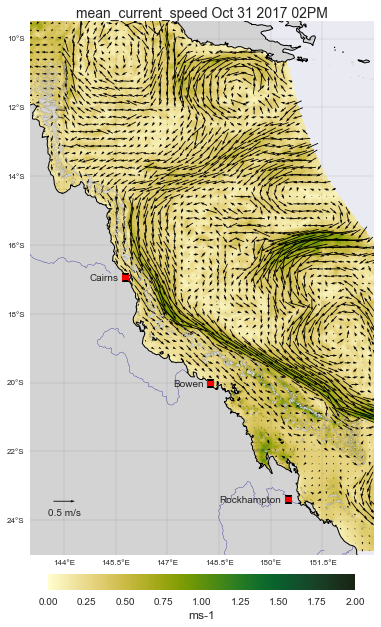

<Figure size 432x288 with 0 Axes>

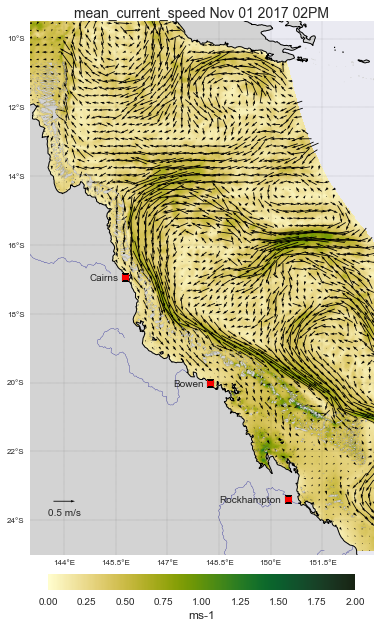

<Figure size 432x288 with 0 Axes>

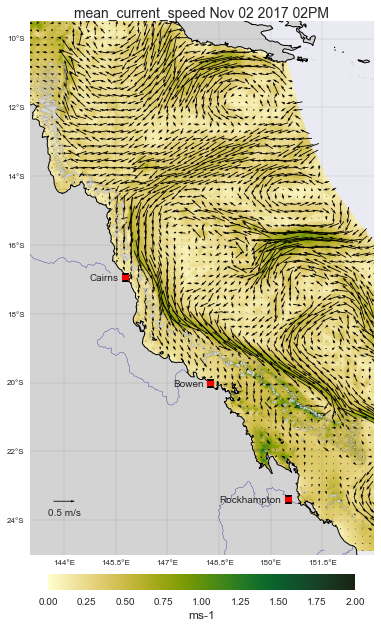

<Figure size 432x288 with 0 Axes>

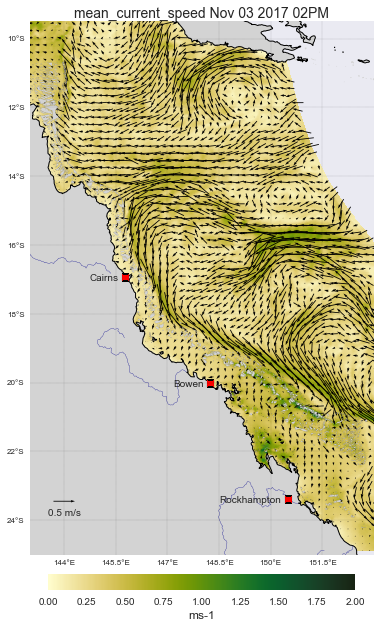

<Figure size 432x288 with 0 Axes>

In [15]:
color = cmocean.cm.speed # Custom colour paletter for velocity
extent = [0,2] # current velocity
size = (9, 10) # Figsize
variable = 'mean_cur'
time = ncdata.variables['time']
timevar=0
images = []

# Loop over each day and create a plot of the salinity
for t in range(len(time)):
    im = ereefs_map(ncdata, t, depthIndex, variable, extent, color, size, figname='mean currents', show=True, save=False)
    #images.append(imageio.v2.imread(im)) # Append each image created to a list for conversion into animation

#Convert images to animation
#animation_name = f'{variable}_{str(year_st)}_{str(year_st+1)}_months_{cots_months[0]}_to_{cots_months[-1]}.gif'
#imageio.mimwrite(animation_name,images)

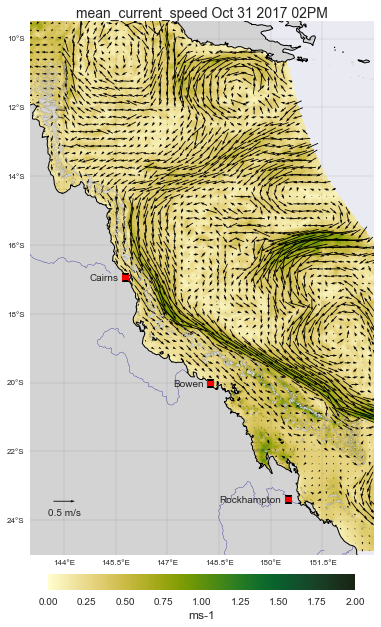

<Figure size 432x288 with 0 Axes>

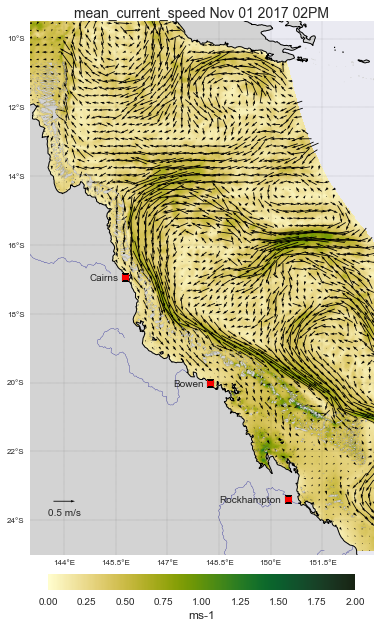

<Figure size 432x288 with 0 Axes>

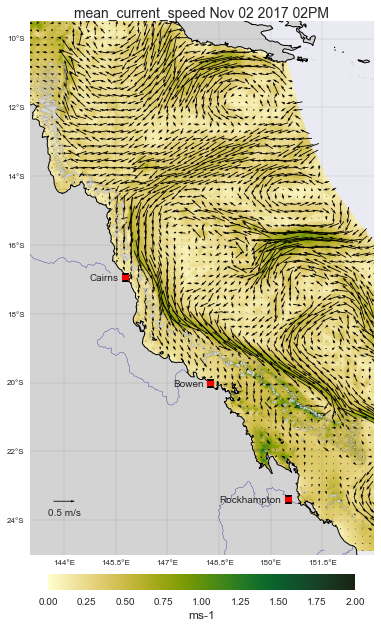

<Figure size 432x288 with 0 Axes>

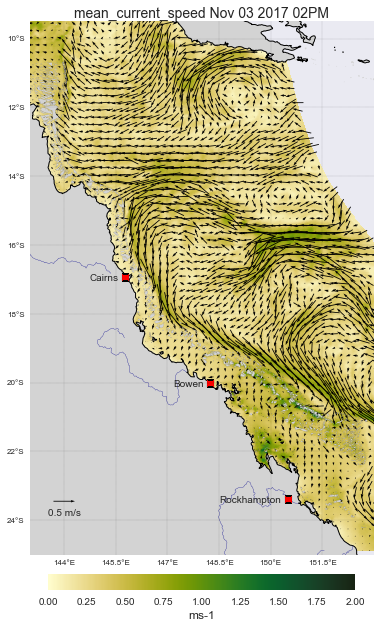

<Figure size 432x288 with 0 Axes>

In [17]:
## Next we will plot for the depth of -1.5m,
# We do not need to define the depth since there is only one depth in each data set. 
#Enter the required parameters:

figname = 'mean currents at -1.5 m'
color = cmocean.cm.speed # Custom colour paletter for velocity
extent = [0,2] # current velocity
size = (9, 10) # Figsize
variable = 'mean_cur'
time = ncdata.variables['time']
images = [] #Set up an empty list of images to append to

# Loop over each day and create a plot of the currents
for t in range(4):
    im = ereefs_map(ncdata2, t, depthIndex, variable, extent, color, size, figname='mean currents at -1.5', show=True, save=False)
    #images.append(imageio.v2.imread(im)) # Append each image created to a list for conversion into animation

#Convert images to animation
#animation_name = f'{variable}_{str(year_st)}_{str(year_st+1)}_months_{cots_months[0]}_to_{cots_months[-1]}.gif'
#imageio.mimwrite(animation_name,images)